In [8]:
##### import necessary packages
from fpdf import FPDF
import json
import os
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import requests
from pypdf import PdfWriter
import threading
import time

In [9]:
def main():

    # start a timer for benchmarking
    start = time.time()
    
    #Read the JSON into class
    with open("report.json") as f:
        report_data = json.load(f)

    #turn JSON into class
    report = Report(report_data)

    report.generateCoverPage() 
    report.generateReport()

    # end benchmark timer
    end = time.time()
    print(f"Execution took {end - start} seconds.")

In [10]:
#utility function        
def getImage(url, title):
    response = requests.get(url)
    if response.status_code == 200:
        with open(str(title)+".png", "wb") as f:
            f.write(response.content)

In [11]:
# define the student class to handle json input and generate the report
class Report:
    def __init__(self, json):
        self.course = json["course"]
        self.progress = int(json["progress"])
        self.sessions = json["sessions"]
        self.session_questions = json["session_questions"]
        self.session_minutes = int(json["session_minutes"])
        self.session_data= pd.DataFrame(json["session_data"])
        self.parent_name = json["parent_name"]
        self.student_name = json["student_name"]
        self.report_date = json["report_date"]
        self.total_questions = json["total_questions"]
        self.join_date = json["join_date"]
        self.question_count = len(json["session_data"])       


                  
    def generateCoverPage(self):

        #declare simple variables
        sessions = self.sessions

        #Make the graph, save it
        df = pd.DataFrame(sessions)

        # Create the figure and axes objects, specify the size and the dots per inches 
        fig, ax = plt.subplots(figsize=(12,7.5), dpi = 96)

        # Plot bars
        bar1 = ax.bar(df['date'], df['correct_session'], width=0.6, color="#00B0F0", label="Correct In session")
        bar12 = ax.bar(df['date'], df['incorrect_session'], width=0.6, color="#D0CECE", bottom = df['correct_session'] + df['correct_nosession'], label="Incorrect In session")
        bar13 = ax.bar(df['date'], df['correct_nosession'], width=0.6, color="#DEEBF7", bottom = df['correct_session'], label="Correct Outside of Session")
        bar14 = ax.bar(df['date'], df['incorrect_nosession'], width=0.6, color="#EDEDED", bottom = df['correct_session'] + df['correct_nosession'] + df['incorrect_session'], label="Incorrect Outside of Session")

        # Reformat x-axis label and tick labels
        ax.set_xlabel('', fontsize=14, labelpad=10) # No need for an axis label
        ax.xaxis.set_label_position("bottom")
        # ax.xaxis.set_major_formatter(lambda s, i : f'{s:,.0f}')
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))
        ax.xaxis.set_tick_params(pad=2, labelbottom=True, bottom=True, labelsize=12, labelrotation=90)
        plt.xticks(df["date"]);

        for c in ax.containers:

            # Optional: if the segment is small or 0, customize the labels
            labels = [v.get_height() if v.get_height() > 0 else '' for v in c]
            
            # remove the labels parameter if it's not needed for customized labels
            ax.bar_label(c, labels=labels, label_type='center', fontsize=12)

        # Reformat y-axis
        ax.set_ylabel('Problems solved', fontsize=14, labelpad=10)
        ax.yaxis.set_label_position("left")
        # ax.yaxis.set_major_formatter(lambda s, i : f'{s:,.0f}')
        ax.yaxis.set_major_locator(MaxNLocator(integer=True))
        ax.yaxis.set_tick_params(pad=2, labeltop=False, labelbottom=True, bottom=False, labelsize=12)

        # Add label on top of each bar
        # ax.bar_label(bar12, labels=[f'{e:,.0f}' for e in df['problems']], padding=3, color='black', fontsize=12) 

        # Remove the spines
        ax.spines[['top','left','bottom','right']].set_visible(False)

        # Make the left spine thicker
        ax.spines['right'].set_linewidth(1.1)

        # Add in line and rectangle on top
        ax.plot([0.12, .9], [.98, .98], transform=fig.transFigure, clip_on=False, color='#398FE5', linewidth=.6)
        # ax.add_patch(plt.Rectangle((0.12,.98), 0.04, -0.02, facecolor='#398FE5', transform=fig.transFigure, clip_on=False, linewidth = 0))

        # Add in title and subtitle
        ax.text(x=0.12, y=.93, s="Questions Solved in the Past 10 Sessions", transform=fig.transFigure, ha='left', fontsize=16, weight='bold', alpha=.8)
        # ax.text(x=0.12, y=.90, s="We target 20 or more questions per session and 80% accuracy, but variances occur due to difficulty", transform=fig.transFigure, ha='left', fontsize=13, alpha=.8)
        ax.legend(loc="upper left", fontsize=12)

        # # Set source text
        # ax.text(x=0.1, y=0.12, s="Note: PrepBox considers 20 or more questions per session to be good performance", transform=fig.transFigure, ha='left', fontsize=10, alpha=.7)

        # Adjust the margins around the plot area
        plt.subplots_adjust(left=None, bottom=0.2, right=None, top=0.85, wspace=None, hspace=None)

        # Set a white background
        fig.patch.set_facecolor('white')
        # Add label on top of each bar
        # ax.bar_label(bar1, labels=[f'{e:,.1f}' for e in delay_by_month['ArrDelay']], padding=3, color='black', fontsize=8) 

        plt.savefig("foo.png")

    def generateAnswerPages(self, i, img1, img2 = ""):
        pdf = FPDF()
        pdf.add_page()
        pdf.set_font('arial', '', 10)

        getImage(img1, i)

        pdf.ln(5)
        pdf.set_font('arial', 'B', 13)
        pdf.cell(7)
        pdf.cell(44, 7, " Question Solved "+str(i+1), 0, 0, "L")
        if self.session_data.accuracy[0] == 1:
            pdf.cell(10,7, " - Correct", 0, 1, "L")
        else:
            pdf.cell(10,7, " - Incorrect", 0, 0, "L")
        pdf.image(str(i)+".png", x=18, y=28, w=150, h=109.489)
        pdf.ln(60)

        if img2:
            getImage(img2, i + 1)
            pdf.set_xy(7, 150)
            pdf.ln(1)
            pdf.cell(7)
            pdf.cell(44, 7, " Question Solved "+str(i+2), 0, 0, "L")
            if self.session_data.accuracy[1] == 1:
                pdf.cell(10,7, " - Correct", 0, 1, "L")
            else:
                pdf.cell(10,7," - Incorrect", 0, 0, "L")
            pdf.image(str(i+1)+".png", x=18, y=165, w=150, h=109.489)

        pdf.output(str(i) + ".pdf")


    def generateReport(self):

        #initialize the instance of the student
        pdf = FPDF()
        pdf.add_page()
        pdf.set_fill_color(57, 143, 229)
        pdf.set_font('arial', 'B', 14)

        #set up of the header with logo
        pdf.set_xy(0, 0)
        pdf.cell(300, 2, "", 0, 1, "C", fill=True)
        pdf.ln(5)
        pdf.image('./Prepbox_logo2.png', x = 77, y = 11, w = 60, h = 0, type = '', link = '')
        pdf.set_font('arial', '', 14)
        pdf.set_text_color(162,162,162)
    
        #The title part
        pdf.ln(30)

        pdf.cell(0, 8, self.student_name +" | Date: "+self.report_date, 0, 1, 'C')

        pdf.ln(1)

        #the separator
        pdf.set_fill_color(162, 162, 162)   
        pdf.cell(10)
        pdf.cell(165, 0.2, "", 0, 1, "C", fill=True)
        pdf.set_fill_color(0, 176, 240)

        pdf.set_text_color(0,0,0)
        pdf.set_font('arial', 'B', 12)
        
        pdf.ln(3)
        
        pdf.cell(0, 8, self.course +" Mastery Level", 0, 1, 'C')

        pdf.ln(3)
        
        pdf.set_font('arial', '', 12)
        pdf.cell(10)
        pdf.cell(35, 10, "",0,0,"L")
        for i in range(0,99):
    #         print(i)
            if i == 0 and i+1 <= self.progress :
                pdf.cell(1,10,"","L,B,T",0,"C", fill=True)   
    #             print("cond1 triggered")
            elif i>0 and i+1 <= self.progress :
                pdf.cell(1,10,"","B,T",0,"C", fill=True)
    #             print("cond2 triggered")
            elif i>0 and i+1 <= self.progress :
                pdf.cell(1,10,"","B,T",0,"C",)
    #             print("cond3 triggered")
            else: 
                pdf.cell(1,10,"","B,T",0,"C")
    #             print("else triggered")
        if self.progress == 100:
            pdf.cell(1,10,"","R,B,T",1,"C", fill=True)
        else:
            pdf.cell(1,10,"","R,B,T",1,"C")
        pdf.set_fill_color(57, 143, 229)    
        pdf.cell(45)
        pdf.cell(self.progress-4, 10, "", 0, 0, "C")
        pdf.cell(10,10,str(self.progress)+"%",0,1,"L")
        pdf.ln(3)
        
        pdf.set_fill_color(162, 162, 162)   
        pdf.cell(10)
        pdf.cell(165, 0.2, "", 0, 1, "C", fill=True)
        pdf.set_fill_color(57, 143, 229)
        pdf.ln(3)
        
        pdf.set_font('arial', 'B', 12)
        pdf.cell(0, 10, "Hi! " +self.student_name +" has just solved", 0, 1, "C")
        pdf.set_font("arial", '', 12)
        pdf.cell(0, 7, str(self.session_questions)+' problems in ' + str(self.session_minutes) +' minutes', 0, 1, "C")
        pdf.ln(3)
        
        
        pdf.set_fill_color(162, 162, 162)   
        pdf.cell(10)
        pdf.cell(165, 0.2, "", 0, 1, "C", fill=True)
        pdf.set_fill_color(57, 143, 229)
        pdf.ln(3)
        
        pdf.set_font('arial', 'B', 12)
        pdf.cell(0, 10, "Overall Performance Trends", 0, 1, "C")
        pdf.set_font('arial', '', 12)
        pdf.cell(0, 7, "Join Date:  "+self.join_date, 0, 1, "C")
        pdf.cell(0, 7, "Questions Solved to Date:  "+ str(self.total_questions), 0, 1, "C")
        pdf.ln(3)

        #add the graph
        pdf.image("foo.png", x = 3, y = 145, w = 200, h = 0, type = '', link = '')

        
    #     pdf.set_fill_color(162, 162, 162)   
    #     pdf.cell(10)
    #     pdf.cell(165, 0.2, "", 0, 1, "C", fill=True)
    #     pdf.set_fill_color(57, 143, 229)
    #     pdf.ln(7)
        
    #     pdf.set_font('arial', 'B', 12)
    #     pdf.cell(0, 8, "Problems Solved over the Past 12 Sessions", 0, 1, 'C')
    #     pdf.ln(5)
    #     pdf.set_text_color(255,255,255)
    #     pdf.cell(57)
    #     pdf.cell(30, 7, "Date",1,0,"C",fill=True)
    #     pdf.cell(50, 7, "Problems Solved",1,1,"C",fill=True)
    #     pdf.set_font('arial', '', 11)
    #     pdf.set_text_color(0,0,0)
    #     for session in sessions:
    #         pdf.cell(57)
    #         pdf.cell(30, 7, session["date"], 1, 0, "C")
    #         pdf.cell(50, 7, str(session["problems"]), 1, 1, "C")
    #     pdf.ln(30)
    #     pdf.set_font('arial', '', 8)

    #    pdf.set_font('arial', '', 10)
    #    pdf.set_xy(0, 270)

        # write cover page
        pdf.output("cover_page.pdf")

        # create answer pages
        procs = list()

        imgl= self.session_data["image"].tolist()
        for i in range(0, len(imgl), 2):
            # not too elegant, but handles if there is only one image on the last page
            try:
                proc = threading.Thread(target = Report.generateAnswerPages, args = (self, i, imgl[i], imgl[i+1]))
            except IndexError:
                proc = threading.Thread(target = Report.generateAnswerPages, args = (self, i, imgl[i]))
            pass
            procs.append(proc)
            proc.start()

        for proc in procs:
            proc.join()
        
        # merge all pages together
        merger = PdfWriter()

        merger.append("cover_page.pdf")

        for i in range(0, len(imgl), 2):
            merger.append(str(i) + ".pdf")

        merger.write("sample_report.pdf")
        merger.close()

Execution took 143.91584730148315 seconds.


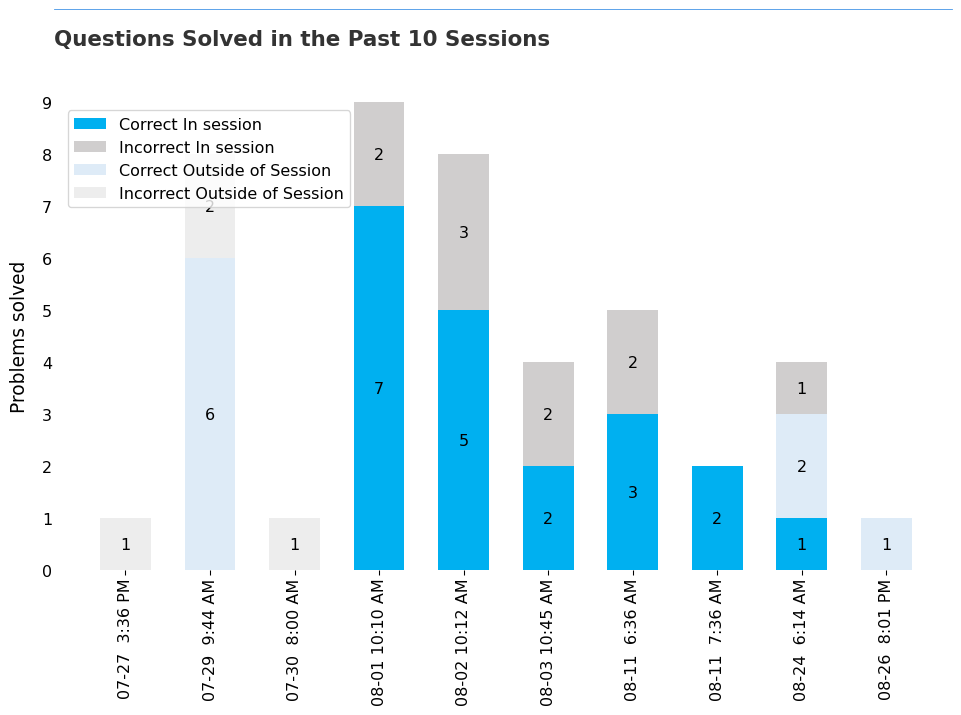

In [7]:
if(__name__=="__main__"):
    main()